In [104]:
dataset_emotion = "emotions-dataset-for-nlp"

#Import Packages:

In [105]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import keras
import nltk
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM ,Conv2D, Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D, MaxPool2D
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib as mpl

#First Step:
building a recurrent neural network capable of analyzing emotions, using a dataset that includes a number of emotions.

In [106]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
porter = PorterStemmer()
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nevena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

class Emotion:
  def __init__(self, datasetFolder, batch_size, validation_split, optimizer, loss, epochs):
    self.datasetFolder = datasetFolder
    self.batch_size = batch_size
    self.validation_split = validation_split
    self.optimizer = optimizer
    self.loss = loss
    self.epochs = epochs
  def readDatasetCSV(self):
    trainDataset = pd.read_csv(os.path.join(self.datasetFolder, "train.txt"), names=['Text', 'Emotion'], sep=';')
    testDataset = pd.read_csv(os.path.join(self.datasetFolder, "test.txt"), names=['Text', 'Emotion'], sep=';')
    validDataset = pd.read_csv(os.path.join(self.datasetFolder, "val.txt"), names=['Text', 'Emotion'], sep=';')
    list_dataset = [trainDataset, testDataset, validDataset]
    self.dataset = pd.concat(list_dataset)
  def FeaturesLables(self):
    self.features = self.dataset['Text']
    self.labels = self.dataset['Emotion']  
  def splitDataset(self):
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.features,
                                                                            self.labels, 
                                                                            test_size = self.validation_split)
  def CleanFeatures(self):
    self.features = self.features.apply(lambda sequence:
                                              [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
    self.features = self.features.apply(lambda wrd: ''.join(wrd))
  def tokenizerDataset(self):
    self.tokenizer = Tokenizer(num_words=5000)
    self.tokenizer.fit_on_texts(self.features)
    train = self.tokenizer.texts_to_sequences(self.features)
    self.features = pad_sequences(train)
    le = LabelEncoder()
    self.labels = le.fit_transform(self.labels)
    self.vocabulary = len(self.tokenizer.word_index)
  def label_categorical(self):
    self.labels = to_categorical(self.labels, 6)
  def glove_word_embedding(self, file_name):
    self.embeddings_index = {}
    file_ = open(file_name, encoding='utf-8')
    for line in file_:
        arr = line.split()
        single_word = arr[0]
        w = np.asarray(arr[1:],dtype='float32')
        self.embeddings_index[single_word] = w
    file_.close()
    max_words = self.vocabulary + 1
    word_index = self.tokenizer.word_index
    self.embedding_matrix = np.zeros((max_words,300)).astype(object)
    for word , i in word_index.items():
            embedding_vector = self.embeddings_index.get(word)
            if embedding_vector is not None:
                self.embedding_matrix[i] = embedding_vector  
  def model(self):
    m = Sequential()
    m.add(Input(shape=(self.features.shape[1], )))
    m.add(Embedding(self.vocabulary + 1,300))
    # m.add(GRU(128, recurrent_dropout=0.3, return_sequences=False, activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    m.add(Dropout(0.2))
    m.add(Bidirectional(CuDNNLSTM(100,return_sequences=True)))
    m.add(Dropout(0.2))
    m.add(Bidirectional(CuDNNLSTM(200,return_sequences=True)))
    m.add(Dropout(0.2))
    m.add(Bidirectional(CuDNNLSTM(100,return_sequences=False)))
    m.add(Dense(6, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001)))
    self.m = m
  def compiler(self):
    self.m.compile(loss= self.loss,optimizer=self.optimizer,metrics=['accuracy'])
  def fit(self):
    earlyStopping = EarlyStopping(monitor = 'loss', patience = 20, mode = 'min', restore_best_weights = True)
    self.history_training = self.m.fit(self.X_train, self.Y_train, epochs= self.epochs,batch_size = self.batch_size,
                                       callbacks=[ earlyStopping])      

In [108]:
emotion = Emotion(dataset_emotion, 256, 0.1, 'adam', 'categorical_crossentropy', 120)

In [109]:
emotion.readDatasetCSV()

In [110]:
emotion.dataset.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [111]:
emotion.FeaturesLables()

In [112]:
emotion.CleanFeatures()

In [113]:
emotion.features.head()

0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
2     im grabbing a minute to post i feel greedy wrong
3    i am ever feeling nostalgic about the fireplac...
4                                 i am feeling grouchy
Name: Text, dtype: object

In [114]:
emotion.labels.unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [115]:
emotion.tokenizerDataset()

In [116]:
emotion.features

array([[   0,    0,    0, ...,  138,    2,  625],
       [   0,    0,    0, ...,    3,   21, 1383],
       [   0,    0,    0, ...,    2,  495,  420],
       ...,
       [   0,    0,    0, ...,    5,  215,  191],
       [   0,    0,    0, ...,   30,   57, 2181],
       [   0,    0,    0, ...,   75,    5,   70]])

In [117]:
emotion.labels

array([4, 4, 0, ..., 2, 2, 2])

In [118]:
emotion.features.shape

(20000, 63)

In [119]:
emotion.features.shape

(20000, 63)

In [120]:
emotion.label_categorical()

In [121]:
emotion.labels

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [122]:
emotion.splitDataset()

In [123]:
emotion.glove_word_embedding("glove.6B.300d.txt")

In [124]:
emotion.model()


In [125]:
emotion.compiler()

In [126]:
emotion.m.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 63, 300)           5129100   
                                                                 
 dropout (Dropout)           (None, 63, 300)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 63, 200)          321600    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 63, 200)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 63, 400)          643200    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 63, 400)          

In [127]:
emotion.fit()

Epoch 1/120


71/71 [==============================] - 13s 133ms/step - loss: 1.3563 - accuracy: 0.4763
Epoch 2/120
71/71 [==============================] - 9s 133ms/step - loss: 0.8298 - accuracy: 0.7071
Epoch 3/120
71/71 [==============================] - 9s 133ms/step - loss: 0.5264 - accuracy: 0.8129
Epoch 4/120
71/71 [==============================] - 9s 132ms/step - loss: 0.3679 - accuracy: 0.8648
Epoch 5/120
71/71 [==============================] - 9s 133ms/step - loss: 0.2990 - accuracy: 0.8874
Epoch 6/120
71/71 [==============================] - 9s 132ms/step - loss: 0.2339 - accuracy: 0.9069
Epoch 7/120
71/71 [==============================] - 9s 132ms/step - loss: 0.2021 - accuracy: 0.9171
Epoch 8/120
71/71 [==============================] - 9s 132ms/step - loss: 0.1750 - accuracy: 0.9248
Epoch 9/120
71/71 [==============================] - 9s 133ms/step - loss: 0.1611 - accuracy: 0.9286
Epoch 10/120
71/71 [==============================] - 9s 134ms/step - loss: 0.1487 - accuracy: 0.9316


C:\Users\Nevena\AppData\Local\Temp\ipykernel_8868\3549910290.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


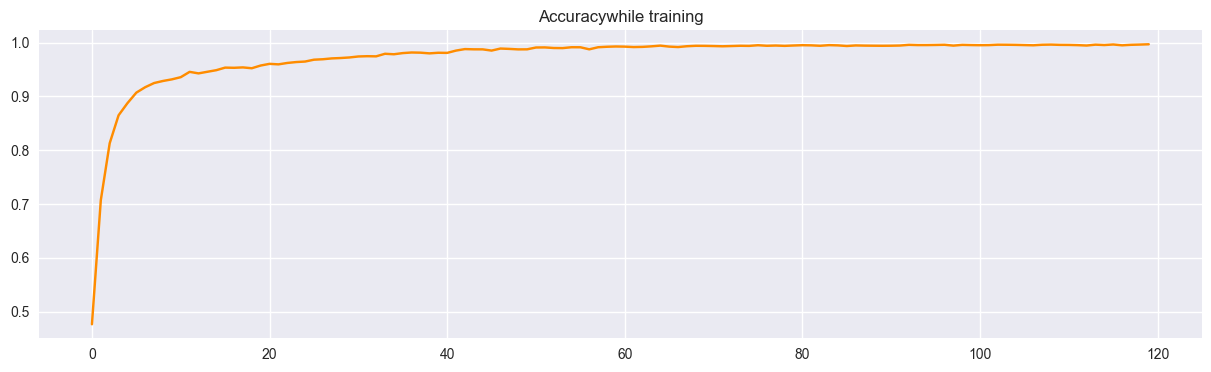

In [128]:
import matplotlib.pyplot as plt
mpl.style.use('seaborn')
figure = plt.figure(figsize=(15, 4))
plt.plot(emotion.history_training.history['accuracy'], 'darkorange', label = 'Accuracy')
plt.title("Accuracywhile training")
plt.show()

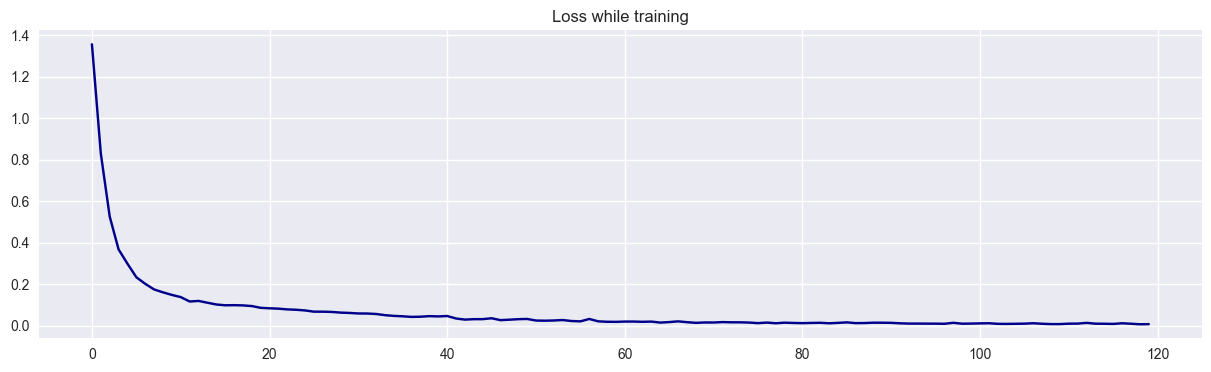

In [129]:
figure = plt.figure(figsize=(15, 4))
plt.plot(emotion.history_training.history['loss'], 'darkblue', label = 'Loss')
plt.title("Loss while training")
plt.show()

In [130]:
emotion.m.evaluate(emotion.X_test, emotion.Y_test, batch_size = 256)

8/8 [==============================] - 1s 99ms/step - loss: 0.3880 - accuracy: 0.9285


[0.38797008991241455, 0.9284999966621399]

In [131]:
y_pred = emotion.m.predict(emotion.X_test)

63/63 [==============================] - 1s 12ms/step


In [132]:
y_pred = np.argmax(y_pred, axis = 1)

In [133]:
y_pred

array([2, 4, 1, ..., 5, 1, 2], dtype=int64)

In [134]:
y_test = np.argmax(emotion.Y_test, axis = 1)

In [135]:
y_test

array([2, 4, 1, ..., 5, 1, 2], dtype=int64)

In [136]:
from sklearn.metrics import accuracy_score as acc
print(acc(y_pred, y_test))

0.9285


In [137]:
res = tf.math.confusion_matrix(y_pred,y_test).numpy()

In [138]:
cm = pd.DataFrame(res,
                     index = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'], 
                     columns = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'])
cm

,sadness,anger,love,surprise,fear,joy
sadness,255,10,4,2,12,0
anger,5,194,2,0,6,11
love,2,1,651,38,0,3
surprise,1,0,24,120,0,0
fear,4,8,0,0,577,0
joy,0,8,2,0,0,60


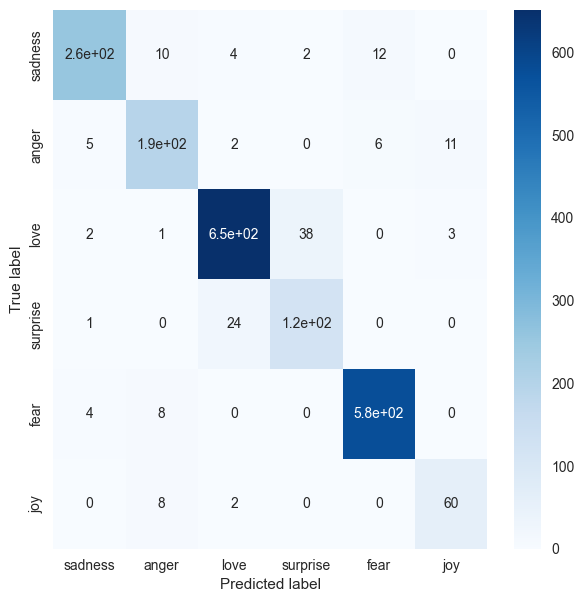

In [139]:
import seaborn as sns
figure = plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [140]:
emotion.m.save("emotion.h5")